# tvb_algo

Numerical algorithms extricated from TVB's library, in order to rebuild a more focused, performant, easier to hack backend. Here's a taste:

In [1]:
%pylab inline
from tvb_algo import data, deint, network

Populating the interactive namespace from numpy and matplotlib


Start by defining a convenience function to configure & run a simulation

In [2]:
W, D = data.tvb76_weights_lengths()

def sim(dt=0.05, tf=150.0, k=0.0, speed=1.0, freq=1.0):
    n = W.shape[0]
    pre = lambda i, j: j - 1.0
    post = lambda gx: k * gx
    prop = network.wm_ring(W, D / speed, dt, pre, post, 1)

    def f(i, X):  # monostable
        x, y = X.T
        c, = prop(i, x.reshape((-1, 1))).T
        dx = freq * (x - x ** 3 / 3 + y) * 3.0
        dy = freq * (1.01 - x + c) / 3.0
        return array([dx, dy]).T

    def g(i, X):  # additive linear noise
        return sqrt(1e-9)

    X = zeros((n, 2))
    Xs = zeros((int(tf / dt),) + X.shape)
    T = r_[:Xs.shape[0]]
    for t, (x, _) in zip(T, deint.em_color(f, g, dt, 1e-1, X)):
        if t == 0:
            x[:] = -1.0
        if t == 1:
            x[:] = rand(n, 2) / 5 + r_[1.0, -0.6]
        Xs[t] = x
    return T, Xs

Now, run and plot

0.674s elapsed


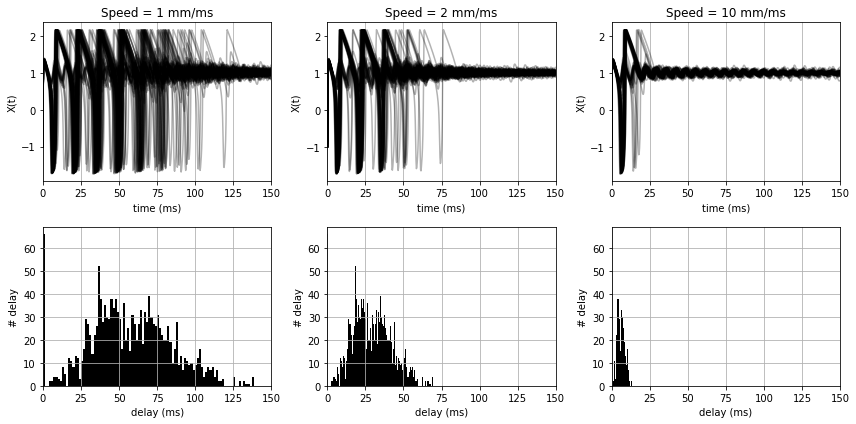

In [3]:
dt = 0.05
figure(figsize=(12, 6))
from time import time
elapsed = 0.0
for i, speed in enumerate([1.0, 2.0, 10.0]):
    tic = time()
    t, x = sim(dt, 150.0, 1e-3, speed)
    elapsed += time() - tic
    subplot(2, 3, i + 1)
    plot(t[::5] * dt, x[::5, :, 0] + 0 * r_[:W.shape[0]], 'k', alpha=0.3)
    grid(True, axis='x')
    xlim([0, t[-1] * dt])
    title('Speed = %g mm/ms' % (speed,))
    xlabel('time (ms)')
    ylabel('X(t)')
    subplot(2, 3, i + 4)
    hist((D[W != 0] / speed).flat[:], 100, color='k')
    xlim([0, t[-1] * dt])
    grid(True)
    xlabel('delay (ms)')
    ylabel('# delay')
tight_layout()
print('%.3fs elapsed' % (elapsed,))
show()

As can be expected, the transient dampens more quickly for faster transmission speeds.

In [ ]:

def _():
    ω = 10.0 / 1e3 * 2 * pi
    dt = (1 / ω) / 10.0
    t, x = sim(dt, 5e3, -1e-2, 10.0, ω=0.02 * pi)
    t = t * dt * 1e-3
    # estimate spectrum
    Fx = abs(fft.fft(x[t > 1, :, 0], axis=0).mean(axis=1))
    fs = fft.fftfreq(Fx.size, dt * 1e-3)

    figure(figsize=(10, 5))
    plot(t[::5], x[::5, :, 0] + 1 * r_[:W.shape[0]], 'k', alpha=0.3), xlabel('time (s)'), ylabel('$x_i(t)$'), ylim(
        [-20, 80])
    ax = axes([0.6, 0.25, 0.3, 0.3], axisbg='w')
    ax.loglog(fs[fs >= 0], Fx[fs >= 0], 'k'), ax.set_yticks([]), ax.set_xlabel('Freq (Hz)'), grid(1);
    tight_layout()

    from time import time as t

    ds = r_[5.0, 10.0, 20.0, 50.0, 100.0]
    et = []
    for ds_i in ds:
        dt = (1 / ω) / ds_i
        tic = t()
        _ = sim(dt, 1e3, -1e-2, 10.0, ω=0.02 * pi)
        et.append(t() - tic)

    loglog((1 / ω) / ds, 1 / array(et), 'ko')
    xlabel('$\Delta t$')
    title('Speed up over realtime')
    grid(True)
